In [45]:

def get_time_domain_plot(data):

    plt.clf()
    plt.title("Time Domain")
    plt.plot(data)


def get_frequency_domain_plot(data, fs):
    fft = np.fft.rfft(data)
    freq = np.fft.rfftfreq(len(data), 1 / fs)
    plt.clf()
    plt.title("Frequency Domain")
    plt.plot(freq, abs(fft))
    plt.xlabel("Frequency")
    plt.ylabel("Number of samples")


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='bandpass', output='sos')
    return sos


def butter_bandpass_filter(data, lowcut=5, highcut=35, fs=250, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    
    filtered_signal = np.zeros_like(data)

    # Loop through each channel of the EMG signal
    for i in range(data.shape[1]):
        filtered_signal[:, i] = sosfilt(sos, data[:,i])

    return filtered_signal


def get_spectogram(data, fs, nfft, overlap):
    plt.title('Spectrogram')
    plt.specgram(data, Fs=fs, NFFT=nfft, noverlap=overlap)
    plt.xlabel("Time Sec")
    plt.ylabel("Frequency Hz")


def remove_dc_offset(data, fs=250, offset=.5, order=3):
    nyq = .5 * fs
    normal_cutoff = offset / nyq
    b, a = butter(N=order, Wn=normal_cutoff, btype='highpass', analog=False)
    fil_data = lfilter(b, a, data)
    return fil_data


def lowpass_filter(data, fs=250, offset=.5, order=3):

    nyq = .5 * fs
    normal_cutoff = offset / nyq
    b, a = butter(N=order, Wn=normal_cutoff, btype='lowpass', analog=False)
    fil_data = lfilter(b, a, data)
    return fil_data


def mains_removal(data, fs=250, notch_freq=60.0, quality_factor=30.0):
    
    data = data.transpose() # For faster computation, data must be in channel, samples
    
    b, a = iirnotch(notch_freq, quality_factor, fs)
    fil_data = filtfilt(b, a, data, padlen=len(data) - 1)
    
    return fil_data.transpose() # Return back to channel, samples




class TimeDomainFeatures:

    def __init__(self, data):

        self.X = data

    def MAV(self, axis=2):  # 1

        mav = np.sum(np.abs(self.X), axis=axis) * 1 / self.X.shape[axis]
        return mav

    def STD(self, axis=2):  # 2
        mu = np.mean(self.X, axis=axis)
        for i, j in enumerate(self.X):
            self.X[i] = (self.X[i].transpose() - mu[i, :]).transpose()

        std = np.sum(np.square(self.X), axis=axis) * (1 / self.X.shape[axis] - 1)
        # std = np.sqrt(std)
        return std

    def VAR(self, axis=2):  # 3
        var = np.sum(np.square(self.X), axis=axis) * (1 / self.X.shape[axis] - 1)
        return var

    def WL(self, axis=2):

        shape = self.X.shape
        X_new = np.zeros(shape)
        for i, j in enumerate(self.X):
            x = self.X[i].transpose()
            for previous in range(x.shape[0]):
                start = previous + 1

                if start == x.shape[0]:
                    xx = x[previous, :]
                    X_new[i, :, previous] = xx
                    break
                else:
                    xx = x[start, :] - x[previous, :]
                    X_new[i, :, previous] = xx

        X_new = np.sum(X_new, axis=axis)
        return X_new

    def RMS(self, axis=2):

        rms = np.sum(np.square(np.abs(self.X)), axis=axis) * 1 / self.X.shape[axis]
        rms = np.sqrt(rms)

        return rms

In [46]:
import os
from biosignal_analysis_tools import *
from scipy.io import loadmat
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy import signal

emg_path = "/home/tipu/Downloads/EEG-EMG-Data/EEG-EMG-Data/EEG-EMG Dataset IEEE/BMIS_EMG_DATA"
eeg_path = "/home/tipu/Downloads/EEG-EMG-Data/EEG-EMG-Data/EEG-EMG Dataset IEEE/BMIS_EEG_DATA"

class Scale:
    mini_volt = 1000
    micro_volt = 1000000

# Functions to load EEG and EMG files for a specific subject and gestures
def get_emg_per_subject_file(subject, no_gesture):
    # Correct base_path construction
    base_path = os.path.join(emg_path, "data/mat_data/subject_{}".format(subject))
    if not os.path.exists(base_path):
        raise FileNotFoundError(f"Directory does not exist: {base_path}")
    
    data_file = os.listdir(base_path)
    gesture = {}
    for i in range(no_gesture):  # Runs through the total number of gestures
        j = i + 1
        gesture[str(i)] = [file for inx, file in enumerate(data_file) if
                           data_file[inx][7] == str(j) or data_file[inx][8] == str(j)]
    return base_path, gesture



def get_eeg_per_subject_file(subject, no_gesture):
    # Correct base_path construction
    base_path = os.path.join(eeg_path, "data/mat_data/subject_{}".format(subject))
    if not os.path.exists(base_path):
        raise FileNotFoundError(f"Directory does not exist: {base_path}")
    
    data_file = os.listdir(base_path)
    gesture = {}
    for i in range(no_gesture):  # Runs through the total number of gestures
        j = i + 1
        gesture[str(i)] = [file for inx, file in enumerate(data_file) if
                           data_file[inx][7] == str(j) or data_file[inx][8] == str(j)]
    return base_path, gesture





# STEP2: Concatenate all gesture together and include respective label as dictionary key
def get_emg_data_per_gesture(subject, no_gesture):
    path, filename = get_emg_per_subject_file(subject, no_gesture)
    gesture = {}

    for i in filename:

        for inx, j in enumerate(filename[i]):  # load individual file
            data = loadmat(os.path.join(path, j))['data']

            if inx == 0:
                stack_data = data

            else:
                stack_data = np.row_stack((stack_data, data))

        gesture[str(i)] = stack_data

    return gesture  # (samples_per_gesture, channels)



def get_eeg_data_per_gesture(subject, no_gesture):
    path, filename = get_eeg_per_subject_file(subject, no_gesture)
    gesture = {}

    for i in filename:

        for inx, j in enumerate(filename[i]):  # load individual file
            data = loadmat(os.path.join(path, j))['data'].transpose()

            if inx == 0:
                stack_data = data

            else:
                stack_data = np.row_stack((stack_data, data))
                
                
        stack_data = stack_data / Scale.micro_volt
        gesture[str(i)] = stack_data

    return gesture  # (samples_per_gesture, channels)



# STEP 3: Preprocessing the data 

def pre_processing_emg(data, emg_fs, notch_freq, quality_factor, fc, fh, order):
    notched_data = mains_removal(data, fs=emg_fs, notch_freq=notch_freq, quality_factor=quality_factor)
    filtered_data = butter_bandpass_filter(notched_data, lowcut=fc, highcut=fh, fs=emg_fs, order=order)

    if filtered_data.any() < 0:
        filtered_data = filtered_data / -128.0
    else:
        filtered_data = filtered_data / 127.0

    return filtered_data.transpose()  # Return as (channel, samples)


def pre_processing_eeg(data, eeg_fs, notch_freq, quality_factor, fc, fh, order):

    notched_data = mains_removal(data, fs=eeg_fs, notch_freq=notch_freq, quality_factor=quality_factor)
    filtered_data = butter_bandpass_filter(notched_data, lowcut=fc, highcut=fh, fs=eeg_fs, order=order)
    filtered_data = filtered_data[250:,:] ##

    return filtered_data.transpose()  # Return as (channel, samples)



# Segementing the data 
#  Segement the data by using sliding window

def window_with_overlap(data, sampling_frequency=250, window_time=1000, overlap=60, no_channel=8):
    samples = int(sampling_frequency * (window_time / 1000))
    num_overlap = int(samples * (overlap / 100))

    num_overlap_samples = samples - num_overlap
    idx = [i for i in range(samples, data.shape[1], num_overlap_samples)]  # data = (channel, samples)

    data_matrix = np.zeros([len(idx), no_channel, samples])  # (samples, channels, samples

    for i, end in enumerate(idx):
        start = end - samples

        if end <= data.shape[1]:
            data_matrix[i] = data[0:no_channel, start:end]

    return data_matrix


def create_label(data, inx):
    label = np.zeros([data.shape[0], 1])
    label.fill(int(inx))
    return label


def shuffle_data(data_emg, data_eeg, label):
    
    size=len(data_eeg)
    classes = len(np.unique(label))
    divs = int(np.floor(size/classes))
    
    emg_data = []
    rev_label = []
    
    for i in range(classes):
        
        random_items = np.random.choice(np.where(np.squeeze(label == i))[0], size=divs, replace=True)
        emg_data.append(data_emg[random_items])
        rev_label.append(label[random_items])
    
    new_emg_data = np.concatenate(emg_data, axis=0)
    new_label = np.concatenate(rev_label, axis=0)
    
    idx = np.random.permutation(len(data_eeg))
    x_emg, x_eeg, y = new_emg_data[idx], data_eeg[idx], new_label[idx]

    return x_emg, x_eeg, y


def get_data_subject_specific(subject, no_gesture, emg_fs, eeg_fs, 
                              notch_freq, quality_factor, emg_fc, emg_fh, 
                              eeg_fc, eeg_fh, order,
                              window_time, overlap, no_channel):
    
    dict_gestures_emg = get_emg_data_per_gesture(subject, no_gesture)
    dict_gestures_eeg = get_eeg_data_per_gesture(subject, no_gesture)
    

    for idx, inx in enumerate(dict_gestures_emg):
        
        
        data_emg = pre_processing_emg(dict_gestures_emg[inx], emg_fs, notch_freq, 
                                  quality_factor, emg_fc, emg_fh, order)
        
        data_eeg = pre_processing_eeg(dict_gestures_eeg[inx], eeg_fs, notch_freq, 
                                  quality_factor, eeg_fc, eeg_fh, order)
        
        
        
        win_data_emg = window_with_overlap(data=data_emg, sampling_frequency=emg_fs, 
                                           window_time=window_time, 
                                       overlap=overlap, no_channel=no_channel)
        
        
        win_data_eeg = window_with_overlap(data=data_eeg, sampling_frequency=eeg_fs, 
                                           window_time=window_time, 
                                       overlap=overlap, no_channel=no_channel)
        
        

        label = create_label(win_data_emg, inx)

        if idx == 0:
            data_stack_emg = win_data_emg
            data_stack_eeg = win_data_eeg
            label_stack = label

        else:
            data_stack_emg = np.row_stack((data_stack_emg, win_data_emg))
            data_stack_eeg = np.row_stack((data_stack_eeg, win_data_eeg))
            label_stack = np.row_stack((label_stack, label))

    X_emg, X_eeg, y = shuffle_data(data_stack_emg, data_stack_eeg, label_stack)

    return X_emg, X_eeg, y

def spilt_data(data, label, ratio):
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=ratio, random_state=42)

    return X_train, y_train, X_test, y_test


def downsample_data(data, nfs, window_time):
    
    n_samples = int(nfs * (window_time/1000))
    downsampled_data = signal.resample(data, n_samples, axis=2)
    
    return downsampled_data


In [47]:
import pandas as pd

# Example usage of the functions
subject = 1
no_gesture = 7
emg_fs = 200
eeg_fs = 250
notch_freq = 60
quality_factor = 30
emg_fc, emg_fh = 5, 50
eeg_fc, eeg_fh = 5, 50
order = 4
window_time = 1000
overlap = 79
no_channel = 8

# Get the processed data
X_emg, X_eeg, y = get_data_subject_specific(
    subject=subject,
    no_gesture=no_gesture,
    emg_fs=emg_fs,
    eeg_fs=eeg_fs,
    notch_freq=notch_freq,
    quality_factor=quality_factor,
    emg_fc=emg_fc,
    emg_fh=emg_fh,
    eeg_fc=eeg_fc,
    eeg_fh=eeg_fh,
    order=order,
    window_time=window_time,
    overlap=overlap,
    no_channel=no_channel,
)

# Convert EMG data to 2D array for saving to CSV
emg_flattened = X_emg.reshape(X_emg.shape[0], -1)
eeg_flattened = X_eeg.reshape(X_eeg.shape[0], -1)

# Combine EMG, EEG, and labels into a single DataFrame
data_emg = pd.DataFrame(emg_flattened)
data_eeg = pd.DataFrame(eeg_flattened)
data_labels = pd.DataFrame(y, columns=["Label"])

# Save EMG data to a CSV file
data_emg.to_csv("processed_emg_data2.csv", index=False)

# Save EEG data to a CSV file
data_eeg.to_csv("processed_eeg_data2.csv", index=False)

# Save labels to a CSV file
data_labels.to_csv("labels2.csv", index=False)

print("Data has been exported to CSV files.")


Data has been exported to CSV files.


In [48]:
# Load the datasets
eeg_data = pd.read_csv('processed_eeg_data2.csv')
emg_data = pd.read_csv('processed_emg_data2.csv')
labels = pd.read_csv('labels2.csv')


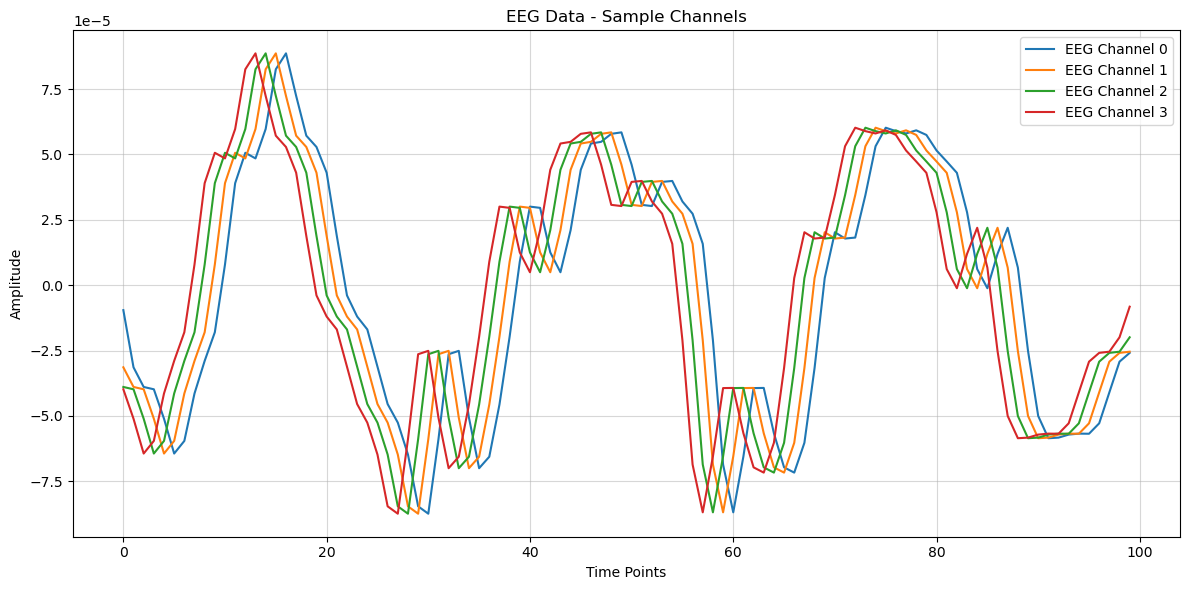

In [49]:
# Plot EEG Data
plt.figure(figsize=(12, 6))

# Plot the first few EEG channels
for channel in range(4):  # Adjust the range for more/less channels
    plt.plot(eeg_data.iloc[0, channel:channel+100].values, label=f'EEG Channel {channel}')

plt.title('EEG Data - Sample Channels')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


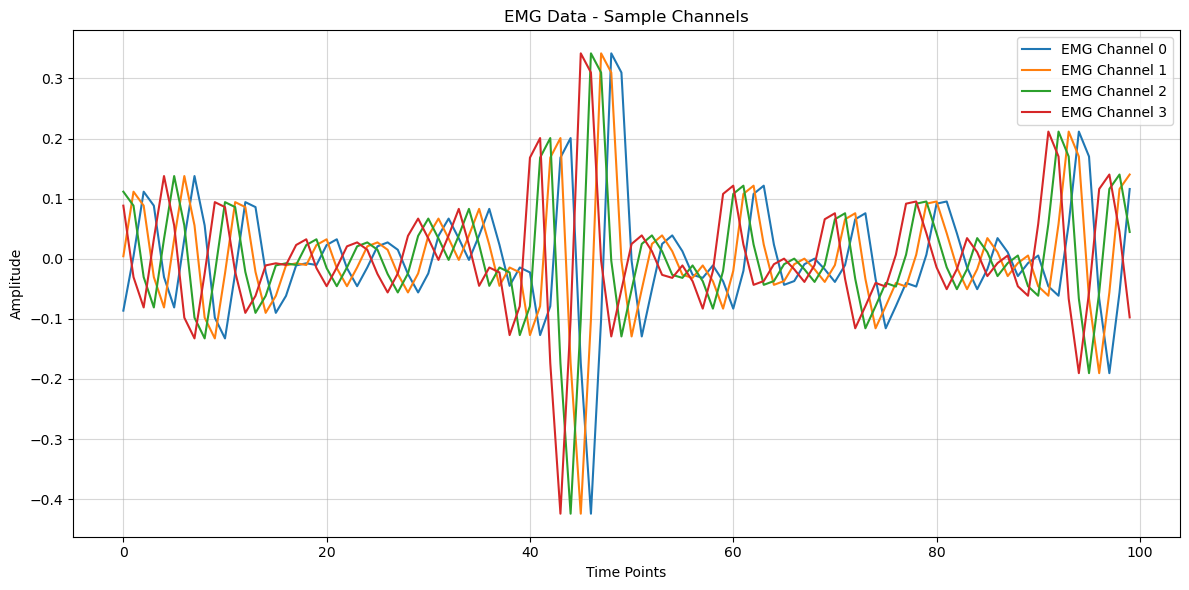

In [50]:

# Plot EMG Data
plt.figure(figsize=(12, 6))

# Plot the first few EMG channels
for channel in range(4):  # Adjust the range for more/less channels
    plt.plot(emg_data.iloc[0, channel:channel+100].values, label=f'EMG Channel {channel}')

plt.title('EMG Data - Sample Channels')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


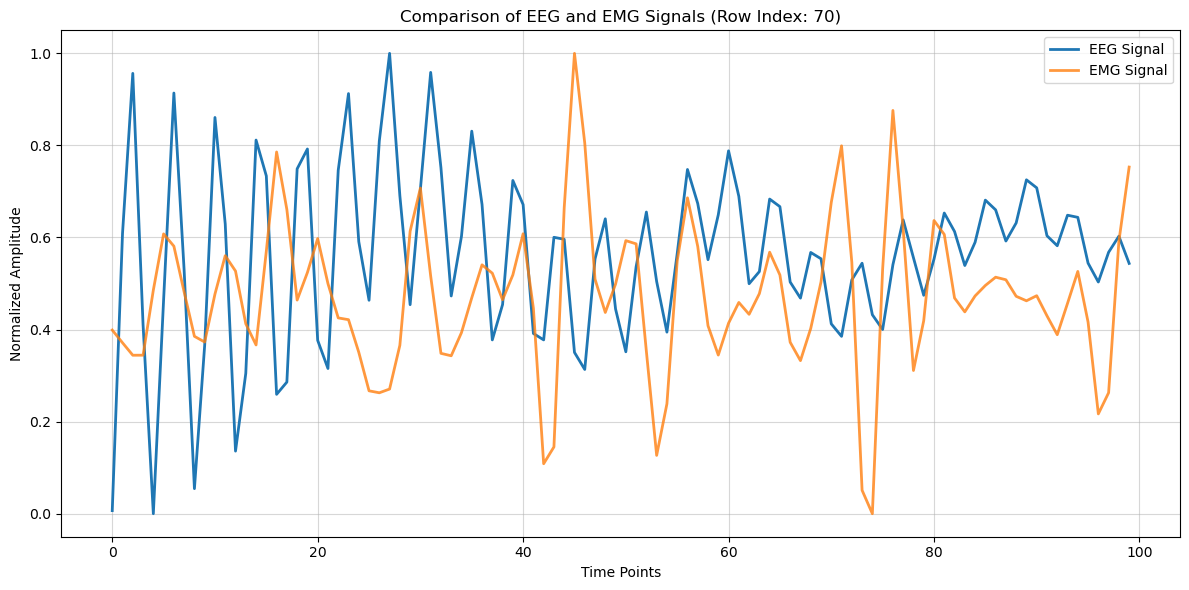

In [51]:
# Select a specific row to plot
row_index = 70  # Change this to select a different row
eeg_signal =eeg_data.iloc[row_index, :100].values  # First 100 data points
emg_signal = emg_data.iloc[row_index, :100].values  # First 100 data points

# Normalize EMG data to match EEG scale for better comparison (optional)
emg_signal = (emg_signal - emg_signal.min()) / (emg_signal.max() - emg_signal.min())
eeg_signal = (eeg_signal - eeg_signal.min()) / (eeg_signal.max() - eeg_signal.min())

# Plot the signals together
plt.figure(figsize=(12, 6))

plt.plot(eeg_signal, label='EEG Signal', linewidth=2)
plt.plot(emg_signal, label='EMG Signal', linewidth=2, alpha=0.8)

# Add titles and labels
plt.title('Comparison of EEG and EMG Signals (Row Index: {})'.format(row_index))
plt.xlabel('Time Points')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [52]:
eeg_duplicates = eeg_data.duplicated().sum()
emg_duplicates = emg_data.duplicated().sum()
label_duplicates = labels.duplicated().sum()


In [53]:
print(f"Number of duplicate rows in EEG data: {eeg_duplicates}")
print(f"Number of duplicate rows in EMG data: {emg_duplicates}")
print(f"Number of duplicate rows in Labels: {label_duplicates}")


Number of duplicate rows in EEG data: 0
Number of duplicate rows in EMG data: 235
Number of duplicate rows in Labels: 924


In [54]:
# Load the EMG data
emg_data = pd.read_csv('processed_emg_data2.csv')

# Find duplicate rows
duplicates = emg_data.duplicated(keep=False)

# Add a small random perturbation to duplicate rows
emg_data.loc[duplicates] = emg_data.loc[duplicates] + np.random.normal(0, 0.001, emg_data.loc[duplicates].shape)

# Save the modified data
emg_data.to_csv('processed_emg_data1.csv', index=False)

print("Duplicates have been made unique and saved as 'processed_emg_data1.csv'.")


Duplicates have been made unique and saved as 'processed_emg_data1.csv'.


In [55]:
# Load the datasets
eeg_data = pd.read_csv('processed_eeg_data2.csv')
emg_data = pd.read_csv('processed_emg_data1.csv')
labels = pd.read_csv('labels2.csv')

# Data augmentation functions
def add_noise(data, noise_level=0.01):
    """Add random noise to the data."""
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def scale_data(data, scale_factor=1.1):
    """Scale the data."""
    return data * scale_factor

def time_shift(data, shift):
    """Shift the data along the time axis."""
    return np.roll(data, shift, axis=0)

def flip_data(data):
    """Flip the data vertically."""
    return -data

# Apply augmentations
augmented_eeg = []
augmented_emg = []
augmented_labels = []

for i in range(len(eeg_data)):
    eeg_row = eeg_data.iloc[i].values
    emg_row = emg_data.iloc[i].values
    label = labels.iloc[i].values[0]

    # Original data
    augmented_eeg.append(eeg_row)
    augmented_emg.append(emg_row)
    augmented_labels.append(label)

    # Augmentation 1: Add noise
    augmented_eeg.append(add_noise(eeg_row))
    augmented_emg.append(add_noise(emg_row))
    augmented_labels.append(label)

    # Augmentation 2: Scale data
    augmented_eeg.append(scale_data(eeg_row))
    augmented_emg.append(scale_data(emg_row))
    augmented_labels.append(label)

    # Augmentation 3: Time shift
    augmented_eeg.append(time_shift(eeg_row, shift=5))
    augmented_emg.append(time_shift(emg_row, shift=5))
    augmented_labels.append(label)

    # Augmentation 4: Flip data
    augmented_eeg.append(flip_data(eeg_row))
    augmented_emg.append(flip_data(emg_row))
    augmented_labels.append(label)

# Convert augmented data to DataFrame
augmented_eeg_df = pd.DataFrame(augmented_eeg, columns=eeg_data.columns)
augmented_emg_df = pd.DataFrame(augmented_emg, columns=emg_data.columns)
augmented_labels_df = pd.DataFrame(augmented_labels, columns=['Label'])

# Save augmented data
augmented_eeg_df.to_csv('augmented_eeg_data.csv', index=False)
augmented_emg_df.to_csv('augmented_emg_data.csv', index=False)
augmented_labels_df.to_csv('augmented_labels.csv', index=False)

print("Data augmentation completed. Augmented files saved.")


Data augmentation completed. Augmented files saved.


In [56]:
emg_duplicates = emg_data.duplicated().sum()
print(f"Number of duplicate rows in EMG data: {emg_duplicates}")

Number of duplicate rows in EMG data: 0


In [57]:
# Load the datasets
eeg_data = pd.read_csv('augmented_eeg_data.csv')
emg_data = pd.read_csv('augmented_emg_data.csv')
labels = pd.read_csv('augmented_labels.csv')

In [58]:
# Print the sizes of the datasets
print(f"EEG Data Size: {eeg_data.shape}")
print(f"EMG Data Size: {emg_data.shape}")
print(f"Labels Size: {labels.shape}")


EEG Data Size: (4655, 2000)
EMG Data Size: (4655, 1600)
Labels Size: (4655, 1)


In [29]:
eeg_duplicates = eeg_data.duplicated().sum()
emg_duplicates = emg_data.duplicated().sum()
label_duplicates = labels.duplicated().sum()


In [30]:
print(f"Number of duplicate rows in EEG data: {eeg_duplicates}")
print(f"Number of duplicate rows in EMG data: {emg_duplicates}")
print(f"Number of duplicate rows in Labels: {label_duplicates}")


Number of duplicate rows in EEG data: 0
Number of duplicate rows in EMG data: 0
Number of duplicate rows in Labels: 5103


Label Distribution:
Label
5.0    665
0.0    665
1.0    665
4.0    665
6.0    665
3.0    665
2.0    665
Name: count, dtype: int64


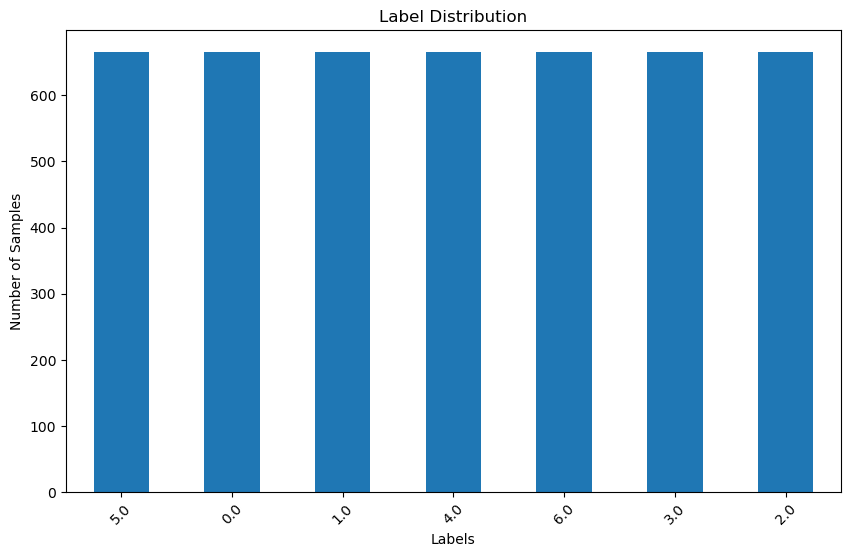


Maximum label count: 665
Minimum label count: 665
Difference between max and min counts: 0

The dataset is fairly balanced.


In [166]:
import matplotlib.pyplot as plt
# Check the distribution of labels
label_distribution = labels['Label'].value_counts()

# Display the distribution
print("Label Distribution:")
print(label_distribution)

# Plot the label distribution
plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

# Check for balance
max_count = label_distribution.max()
min_count = label_distribution.min()
print("\nMaximum label count:", max_count)
print("Minimum label count:", min_count)
print("Difference between max and min counts:", max_count - min_count)

if max_count - min_count <= 0.1 * max_count:
    print("\nThe dataset is fairly balanced.")
else:
    print("\nThe dataset is imbalanced. Consider applying techniques to balance it.")

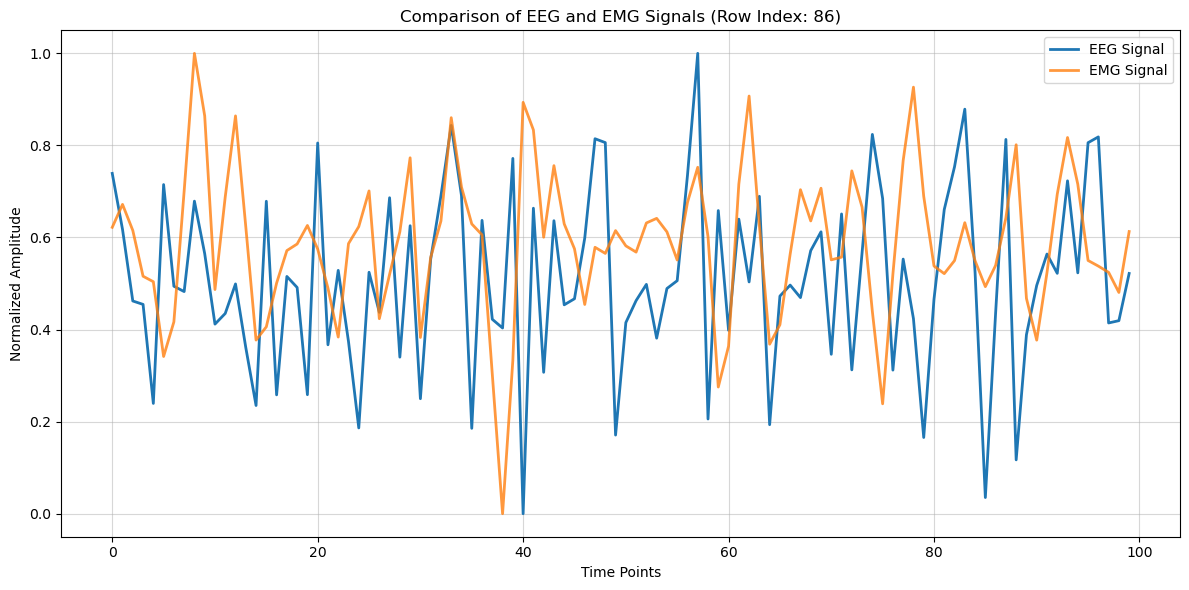

In [167]:
# Select a specific row to plot
row_index = 86  # Change this to select a different row
eeg_signal = eeg_data.iloc[row_index, :100].values  # First 100 data points
emg_signal = emg_data.iloc[row_index, :100].values  # First 100 data points

# Normalize EMG data to match EEG scale for better comparison (optional)
emg_signal = (emg_signal - emg_signal.min()) / (emg_signal.max() - emg_signal.min())
eeg_signal = (eeg_signal - eeg_signal.min()) / (eeg_signal.max() - eeg_signal.min())

# Plot the signals together
plt.figure(figsize=(12, 6))

plt.plot(eeg_signal, label='EEG Signal', linewidth=2)
plt.plot(emg_signal, label='EMG Signal', linewidth=2, alpha=0.8)

# Add titles and labels
plt.title('Comparison of EEG and EMG Signals (Row Index: {})'.format(row_index))
plt.xlabel('Time Points')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [168]:
# Print the sizes of the datasets
print(f"EEG Data Size: {eeg_data.shape}")
print(f"EMG Data Size: {emg_data.shape}")
print(f"Labels Size: {labels.shape}")


EEG Data Size: (4655, 2000)
EMG Data Size: (4655, 1600)
Labels Size: (4655, 1)


In [169]:
import pandas as pd
import numpy as np

# Load the datasets
eeg_data = pd.read_csv('augmented_eeg_data.csv')
emg_data = pd.read_csv('augmented_emg_data.csv')
labels = pd.read_csv('augmented_labels.csv')

# Get the target shape from EMG data
emg_shape = emg_data.shape[1]

# Adjust EEG data shape to match EMG data
if eeg_data.shape[1] > emg_shape:
    # Truncate EEG data
    eeg_data = eeg_data.iloc[:, :emg_shape]
elif eeg_data.shape[1] < emg_shape:
    # Pad EEG data with zeros to match EMG shape
    padding = emg_shape - eeg_data.shape[1]
    eeg_data = pd.concat([eeg_data, pd.DataFrame(np.zeros((eeg_data.shape[0], padding)))], axis=1)

# Ensure all data has the same number of rows
min_rows = min(eeg_data.shape[0], emg_data.shape[0], labels.shape[0])
eeg_data = eeg_data.iloc[:min_rows, :]
emg_data = emg_data.iloc[:min_rows, :]
labels = labels.iloc[:min_rows, :]

# Save the adjusted datasets
eeg_data.to_csv('adjusted_eeg_data.csv', index=False)
emg_data.to_csv('adjusted_emg_data.csv', index=False)
labels.to_csv('adjusted_labels.csv', index=False)

print("EEG, EMG, and label datasets have been adjusted and saved.")


EEG, EMG, and label datasets have been adjusted and saved.


In [170]:
# Print the sizes of the datasets
eeg_data = pd.read_csv('adjusted_eeg_data.csv')
emg_data = pd.read_csv('adjusted_emg_data.csv')
labels = pd.read_csv('adjusted_labels.csv')


print(f"EEG Data Size: {eeg_data.shape}")
print(f"EMG Data Size: {emg_data.shape}")
print(f"Labels Size: {labels.shape}")


EEG Data Size: (4655, 1600)
EMG Data Size: (4655, 1600)
Labels Size: (4655, 1)


In [ ]:
# Select a specific row to plot
row_index = 30  # Change this to select a different row
eeg_signal = eeg_data.iloc[row_index, :50].values  # First 100 data points
emg_signal = emg_data.iloc[row_index, :50].values  # First 100 data points

# Normalize EMG data to match EEG scale for better comparison (optional)
emg_signal = (emg_signal - emg_signal.min()) / (emg_signal.max() - emg_signal.min())
eeg_signal = (eeg_signal - eeg_signal.min()) / (eeg_signal.max() - eeg_signal.min())

# Plot the signals together
plt.figure(figsize=(12, 6))

plt.plot(eeg_signal, label='EEG Signal', linewidth=2)
plt.plot(emg_signal, label='EMG Signal', linewidth=2, alpha=0.8)

# Add titles and labels
plt.title('Comparison of EEG and EMG Signals (Row Index: {})'.format(row_index))
plt.xlabel('Time Points')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()
